# Notebook 3: Intro to Object Detection

In [1]:
import time
import copy
import cv2
import torch
import numpy as np
import imageio
import pickle as pkl
from PIL import Image
from IPython import display
from torchvision import datasets, transforms, models
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

# Basic Vechicle Detection

So far, we have covered the basic task of image recognition. In this notebook, we will explore how to train computers to not only classify images, but also detect objects in an image as well. We will first cover the basics of bounding boxes and then learn how to adapt pretrained classification models to build a vechicle classifiers. We then apply this classifier to bounding boxes using sliding window and selective search techniques to create a simple object detector.

# Sliding Windows

We will be working with the following image of a city road, which we will apply objection detection to.

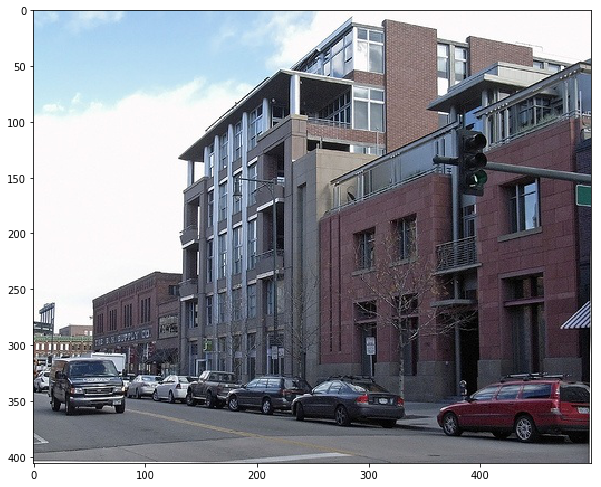

In [2]:
fname = 'notebook4_images/img.jpg'
img = Image.open(fname)

plt.figure(figsize = (10, 10))
plt.imshow(img)

We first introduce a simple sliding window technique in which we use slide through the image, looking at cropped images of a fixed fixed size. We provide for creating a gif that illustrates how this technique works.

In [3]:
def sliding_window(image, stepSize, windowSize):
    """
    Slides a window across an image

    Args:
        image (np array): Input image
        stepSize (int): Step size for sliding window (both in x and y directions)
        windowSize (int tuple): (window width, window height)

    Yields:
        yields x and y coordinates of the upper-lefthand corner and the cropped image (np array)
    """
    
    # slide a window across the image
    for y in range(0, image.shape[0], stepSize):
        for x in range(0, image.shape[1], stepSize):
            # yield the current window
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])
            

def sliding_gif(image, gif_fname, stepSize=64, winW=128, winH=128, gif_scale=0.5):
    """
    Saves a gif sliding windows on an image

    Args:
        image (np array): Input image
        gif_fname (string): Save file name
        stepSize (int): How much to slide across the image
        winW (int): Window width
        winH (int): Window height
        gif_scale (float): Scale the size of the gif (smaller scale = faster processing)
    """
    height, width, _ = image.shape
    width_gif = int(width * gif_scale)
    height_gif = int(height * gif_scale)

    images = []

    for (x, y, window) in sliding_window(image, stepSize=stepSize, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        clone = image.copy()
        cv2.rectangle(clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
        clone = cv2.resize(clone, (width_gif, height_gif))
        images.append(Image.fromarray(clone))

    imageio.mimwrite(gif_fname, images, duration=0.1)

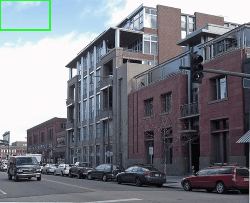

In [4]:
# Feel free to play around with the step size and window dimensions
stepSize = 50
winW = 100
winH = 60

image = np.array(img)
fname = "notebook4_images/sliding.gif"
sliding_gif(image, fname, stepSize=stepSize, winW=winW, winH=winH)
display.Image(filename=fname)

# Adding image classification

Now given a set of cropped images, we can perform image classification on each window. In the previous notebook, we had you build your own image recognition model. Here instead, we will use a pre-trained residual network (ResNet-50), which has been shown to do well on image classification tasks while being relatively lightweight. 

The diagram below plots the top-1% accuracy of popular image models on ImageNet against the operations required for an image to be passed through the network to generate a prediction. The size of each blob is proportional to the number of parameters of the neural network. Generally, larger models require more space and computational resources. As seen in the figure, ResNets generally offer a fairly good balance between performance and memory. For example, compare ResNet-50 to its predecessors, VGG-16 and VGG-19, which achieves worse accuracy and has much higher computation and memory costs.

![compare models](notebook4_images/image_model_comparison.png)

https://arxiv.org/abs/1605.07678

In [5]:
# load ResNet-50
# We set the argument pretrained=True, which downloads the weights for the model
# that are pretrained on the ImageNet database.
model = models.resnet50(pretrained=True)
model.eval() # will print out the layers of the model (feel free to ignore)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

Let us first try classifying the van in the lower-lefthand corner. First find a bounding box around the van. We provide code below that will visualize the bounding box using your chosen inputs.

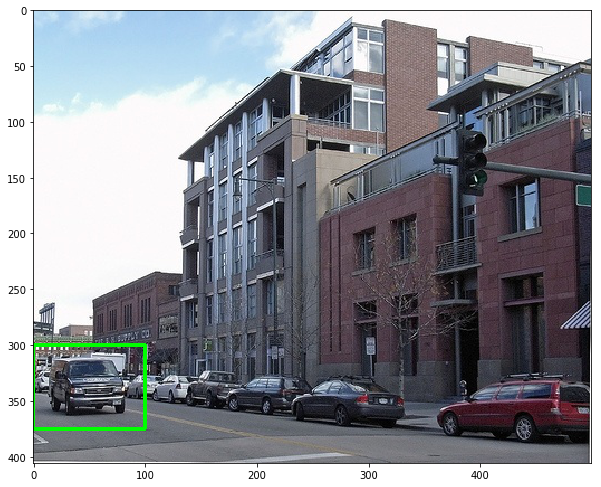

In [6]:
# TODO: Adjust the following values of the upper-lefthand and lower-righthand corners of the bounding box
x1 = 0
x2 = 100
y1 = 300
y2 = 375

image = np.array(img)
clone = image.copy()
cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 255, 0), 2)

plt.figure(figsize = (10, 10))
plt.imshow(clone)

Now we will get the top 5 class labels for the cropped image.

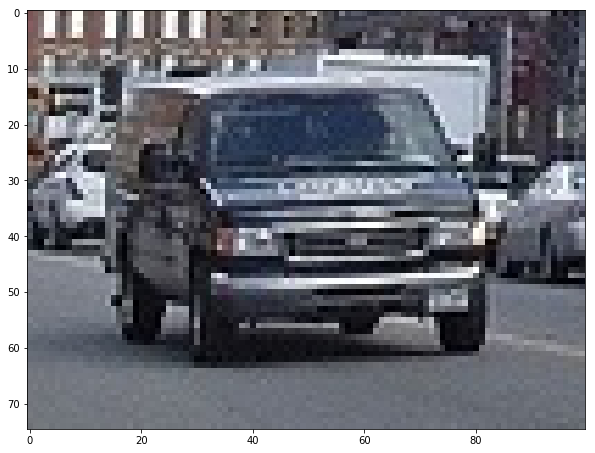

In [7]:
# TODO: Use the coordinates you settled on in the previous cell {x1, x2, y1, y2} to create a cropped image
# Feel free to show the image using plt.imshow() to verify that you have cropped the image correctly
cropped = image[y1:y2, x1:x2]

plt.figure(figsize = (10, 10))
plt.imshow(cropped)

We now run the image through our neural network to generate predictions.

In [8]:
# converts from a numpy array to a PIL image
cropped = Image.fromarray(cropped)

"""
transform the image (standard for our ResNet model):
1) resize the image to 256x256
2) apply a center crop to get a final output size of 224x224 (which is the required input size for our ResNet architecture)
3) convert the image to a pytorch Tensor format
4) normalize the image channels
"""
transform = transforms.Compose([transforms.Resize([256,256]),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
cropped = transform(cropped).unsqueeze(0)

# run the image through our model and convert the output from a pytorch tensor to a numpy array format
preds = model(cropped).detach().numpy()

In [9]:
# loads a dictionary that maps the label value to the class label name
with open('notebook4_data/imagenet_dict.pkl', 'rb') as handle:
    imagenet_dict = pkl.load(handle)

#TODO: Get the top 5 scoring labels and class label names (using imagenet_dict)
k = 5
top_k = preds.argsort()[0][-k:][::-1]

for i, idx in enumerate(top_k):
    print(i + 1, imagenet_dict[idx])

1 moving van
2 cassette player
3 trailer truck, tractor trailer, trucking rig, rig, articulated lorry, semi
4 tow truck, tow car, wrecker
5 garbage truck, dustcart


# Transfer Learning

Next, we wil use transfer learning to build a model that does binary classification with class labels: vehicle and no vehicle.

Developing state-of-the-art models often requires vast amounts of data and computational resources. Moreover, even when given a specific model architecture, researchers often spend significant time tuning hyperparameters in order to push the performance of their model. As a result, it is not unheard of for research lab teams to have access to clusters with hundreds of GPUs. We however could not expect you to train from scratch a state-of-the-art image recognition model on a large image database, such as ImageNet, given the limited time and computational resources.

To circumvent this issue, we introduce a popular approach called transfer learning, which is a method where a model adapted for some task is adapted as a starting point for another task.

![transfer_learning](notebook4_images/transfer_learning.png)

One interpretation of neural networks for images is that each layer can be thought of as a feature extractor, where the last layer uses the learned features to make a final prediction. 

![cnn_feature_extractor](notebook4_images/cnn_feature_extractor.png)

Thus, we can use the weights of a pretrained neural network as a starting point for training a model on a new task. In our case, we will keep the feature map layers and modify the final fully connected layer (classifier). You can think of this as essentially "transferring knowledge" learned in the feature extractor layers. For example, if we started with the ResNet above, we already have a very good feature extractor that has seen over a million examples from the ImageNet dataset. Then we simply finetune the model for a different task using a new image dataset.

For our notebook, we will use ResNet-18 as are pretrained model. Then we will train our model a new dataset of vehicles (CIFAR-100)

# CIFAR-100

We use the CIFAR-100 dataset (see: https://www.cs.toronto.edu/~kriz/cifar.html), which has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class.

In [10]:
# we create two dictionaries that map the class label name to the label number (and vice-versa)
with open('notebook4_data/cifar100/cifar-100-python/meta', 'rb') as handle:
    classes = pkl.load(handle)['fine_label_names']

class_to_idx = {}
idx_to_class = {}
for idx, class_name in enumerate(classes):
    class_to_idx[class_name] = idx
    idx_to_class[idx] = class_name

In [11]:
# see the list of class names
class_to_idx.keys()

dict_keys(['otter', 'bus', 'cloud', 'camel', 'keyboard', 'raccoon', 'oak_tree', 'bowl', 'bottle', 'chimpanzee', 'turtle', 'sea', 'skunk', 'leopard', 'castle', 'lamp', 'orange', 'shark', 'lion', 'lobster', 'kangaroo', 'tractor', 'house', 'forest', 'road', 'dolphin', 'caterpillar', 'streetcar', 'tiger', 'tank', 'sweet_pepper', 'snail', 'crab', 'poppy', 'tulip', 'hamster', 'clock', 'television', 'motorcycle', 'couch', 'train', 'woman', 'willow_tree', 'can', 'shrew', 'seal', 'porcupine', 'flatfish', 'plain', 'chair', 'skyscraper', 'mouse', 'man', 'palm_tree', 'girl', 'bed', 'rocket', 'pear', 'squirrel', 'beetle', 'mushroom', 'maple_tree', 'crocodile', 'wolf', 'spider', 'bear', 'possum', 'aquarium_fish', 'rose', 'bridge', 'pine_tree', 'fox', 'boy', 'apple', 'elephant', 'cockroach', 'beaver', 'pickup_truck', 'mountain', 'lawn_mower', 'bee', 'sunflower', 'orchid', 'wardrobe', 'ray', 'table', 'telephone', 'dinosaur', 'snake', 'cattle', 'bicycle', 'cup', 'lizard', 'trout', 'worm', 'plate', 'but

In [12]:
# get the label index for the class "streetcar"
print(class_to_idx['streetcar'])

# and vice-versa
print(idx_to_class[81])

81
streetcar


# Modifying CIFAR for our needs

We need to modify our dataset now so that we only have two classes, vehicle and not vehicle. Using the dictionaries you have loaded, look through the class names and find the relevant vehicle classes (Feel free to change this to a multilabel classification if you wish to distinguish between different types of vehicles). 

Note, you can directly modify the labels by changing the numpy arrays: dataset_train.train_labels and dataset_test.test_labels

In [13]:
"""
Again, we transform the images before feeding them into the network. We add an additional transformation called
RandomHorizontalFlip. Every time the data loader feeds the image through the model, it will randomly flip the image
with probability p=0.5. This improves training by essentially augmenting our image dataset with more images that have
been slightly adjusted.
"""
trans_cifar_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.Resize([256,256]),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Same transform for the validation set, although since these are test examples, we don't want to flip them
trans_cifar_val = transforms.Compose([transforms.Resize([256,256]),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

dataset_train = datasets.CIFAR100('notebook4_data/cifar100', train=True, download=True, transform=trans_cifar_train)
dataset_test = datasets.CIFAR100('notebook4_data/cifar100', train=False, download=True, transform=trans_cifar_val)


def get_modified_labels(dataset, train=True):
    """
    Modifies the y-labels of the CIFAR100 dataset so that we only labels for the classes we care about (vehicles)
    and sets all other class labels to 0. Example: if we only cared about dogs and cats, we would change the label
    of any dog image to 1, the label of any cat image to 2, and change the labels of all other examples to 0.
    
    Args:
        dataset: CIFAR100 dataset
        train: denotes whether it is the test or test set

    Returns:
        labels: array of modified labels
        percent_background: percentage of modified labels that are of the background class
    """
    if train:
        labels = dataset.train_labels
    else:
        labels = dataset.test_labels
    labels = np.array(labels)
        
    mask_bus = labels == class_to_idx['bus']
    mask_motorcycle = labels == class_to_idx['motorcycle']
    mask_truck = labels == class_to_idx['pickup_truck']
    mask_car = labels == class_to_idx['streetcar']
    
    mask_vehicles = mask_bus | mask_motorcycle | mask_truck | mask_car
    mask_background = np.invert(mask_vehicles)
    percent_background = mask_background.mean()
    
    labels[mask_bus] = 1
    labels[mask_motorcycle] = 2
    labels[mask_truck] = 3
    labels[mask_car] = 4
    labels[mask_background] = 0
        
    return labels, percent_background

# Modify the y labels of the CIFAR100 dataset objects
dataset_train.train_labels, percent_background = get_modified_labels(dataset_train, train=True)
dataset_test.test_labels, _ = get_modified_labels(dataset_test, train=False)

Files already downloaded and verified
Files already downloaded and verified


# Training our model!

The pretrained ResNet models from the torchvision package are trained on ImageNet, which as 1000 classes. We first modify the model so that it can be adapted to our dataset (which has much fewer classes). We then define a helper function that we will call to train the model.

In [14]:
class ResnetCifar(nn.Module):
    """
    Class for ResNet-18 model with a modified number of output classes
    
    Args:
        num_classes: number of prediction class labels
    """
    def __init__(self, num_classes=100):
        super(ResnetCifar, self).__init__()
        self.model = models.resnet18(pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = True
        num_features = self.model.fc.in_features
        self.model.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)
    

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    """
    Trains our model
    
    Args:
        model: PyTorch model to be trained
        dataloaders: dictionary of train and test dataloader (with keys 'train' and 'val')
        criterion: pytorch loss criterion (example: cross-entropy)
        optimizer: pytorch optimizer (example: stochastic gradient descent)
        scheduler: pytorch scheduler for learning rate decay
        num_epochs = number of epochs to train for
    """
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float("inf")

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_count = 0
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_count += len(labels)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / running_count
            epoch_acc = running_corrects.double() / running_count

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Let us define all the necessary variables to pass to the train_model function

In [18]:
# use GPU if it is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# change num_classes if you have more than 2 classes
num_classes = 5
model = ResnetCifar(num_classes=num_classes)
model = model.to(device)

# create dictionary of dataloaders for train and test sets
batch_size = 128
dataloaders = {}
dataloaders['train'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
dataloaders['val'] = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)

w = percent_background * 100
class_weights = np.ones(num_classes) * w
class_weights[0] = 1.0
class_weights = torch.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

# use stocahstic gradient descent for optimization
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)

# decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Now we can call train_model to train our image classification model.

In [19]:
# train and save the best model
model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

Epoch 0/4
----------
train Loss: 0.6162 Acc: 0.8276


KeyboardInterrupt: 

# Finally combine sliding windows and our vehicle classifier to create a simple object detector!

Implement the sliding_predictions function. This function is similar to the sliding_gif function, except that instead of appending images to a list and writing the list to a gif file, you are cropping each image and running the cropped image through the neural network to see if there is a vehicle.

class: 1, acc: 0.708121


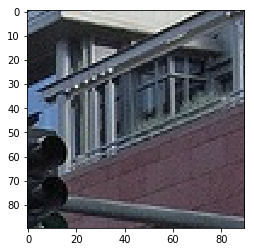

class: 1, acc: 0.914344


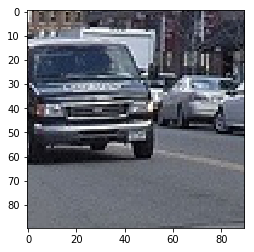

class: 1, acc: 0.776175


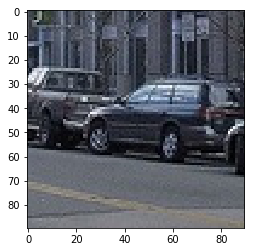

class: 3, acc: 0.844113


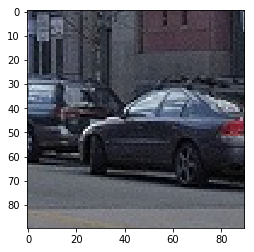

class: 3, acc: 0.919114


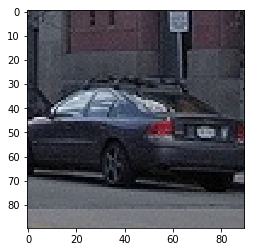

class: 3, acc: 0.711540


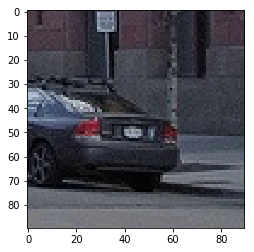

class: 3, acc: 0.985274


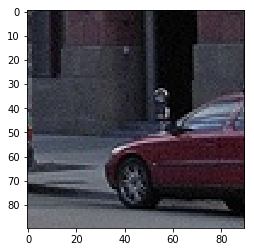

class: 3, acc: 0.925692


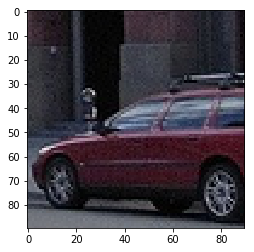

class: 1, acc: 0.883678


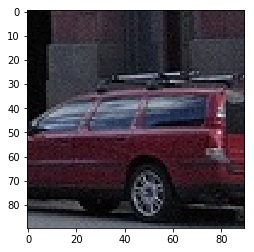

In [17]:
def sliding_predictions(image, model, stepSize=64, winW=128, winH=128, threshold=0.7):
    """
    Slides across an image and determines if there is a vehicle in each window

    Args:
        image (np array): Input image
        model: Image classification model
        stepSize (int): How much to slide across the image
        winW (int): Window width
        winH (int): Window height
        threshold (float): minimum accuracy required to detect an image
    """
    height, width, _ = image.shape

    for (x, y, window) in sliding_window(image, stepSize=stepSize, windowSize=(winW, winH)):
        # if the window does not meet our desired window size, ignore it
        if window.shape[0] != winH or window.shape[1] != winW:
            continue

        cropped = image[y:y + winH, x:x + winW]
        cropped = Image.fromarray(cropped)
        cropped = trans_cifar_val(cropped).unsqueeze(0)
        cropped = cropped.to(device)
        output = model(cropped).cpu().detach().numpy()
        pred = np.argmax(output)
        pred_acc = np.exp(output[0])[pred]
        if pred != 0 and pred_acc > threshold:
            print('class: %d, acc: %f' % (pred, pred_acc))
            plt.imshow(image[y:y + winH, x:x + winW])
            plt.show()

sliding_predictions(image, model, stepSize=30, winW=90, winH=90, threshold=0.7)